### 5.3 DNN

In [3]:
import os
os.chdir('/Users/apple/Documents/PHBS_TQFML/Project/Code')
import numpy as np
import pandas as pd
import os
import feature_funcs as ff
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
import keras.optimizers
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
%matplotlib inline
current_path = os.getcwd()
data_path = os.path.dirname(os.getcwd()) + '/Data/'

#### 5.3.1. Feature Preprocessing
* **All features** are used in training
* To increase training speed, the data are **standardized**
* **'cw'** parameter in keras is used to tackle the 'imbalance dataset' problem
* We train on **70%** of the sample and test on **30%** of the sample

In [4]:
traindf = pd.read_csv(data_path + 'traindf.csv')

In [5]:
X_raw=traindf.iloc[:,1:75].values
y_raw=traindf.iloc[:,-1].values

x_train, x_test, y_train, y_test = train_test_split(
    X_raw, y_raw, test_size=0.3, random_state=1)

sc = StandardScaler()
sc.fit(x_train)
x_train = sc.transform(x_train)
x_test = sc.transform(x_test)

#### 5.3.2. DNN Structures after hyperparameter tunning
* We use **keras** package with tensorflow as kernel
* **Sequential** Model is used
* 1 input layer, 5 hidden layers, 1 output layers
* Input and all the hidden layers employ '**ReLu**' activation function
* The output layer employs '**Sigmoid**' activation function
* Parameter cw = {0: 1, 1: 5.32} indicates that we give more weights on '1' label because of the **imbalance dataset**
* The loss function we used in back propagation is '**binary_crossentropy**'
* **Adam optimizer** is used because it considers both momentum effect and avoids gradient exposure

In [6]:
model = Sequential()
model.add(Dense(128, activation = 'relu', input_dim = x_train.shape[1]))
model.add(Dense(64, activation = 'relu'))
model.add(Dense(128, activation = 'relu'))
model.add(Dense(64, activation = 'relu'))
model.add(Dense(128, activation = 'relu'))
model.add(Dense(64, activation = 'relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08),
              metrics=['accuracy'])

* Start training

In [7]:
model.fit(x_train, y_train, epochs=20, batch_size = 1024)

Epoch 1/20
243154/243154 [==============================] - 5s 21us/step - loss: 0.4370 - acc: 0.8399
Epoch 2/20
243154/243154 [==============================] - 5s 20us/step - loss: 0.3541 - acc: 0.8624
Epoch 3/20
243154/243154 [==============================] - 5s 22us/step - loss: 0.3481 - acc: 0.8641
Epoch 4/20
243154/243154 [==============================] - 5s 20us/step - loss: 0.3457 - acc: 0.8647
Epoch 5/20
243154/243154 [==============================] - 5s 21us/step - loss: 0.3446 - acc: 0.8650
Epoch 6/20
243154/243154 [==============================] - 5s 19us/step - loss: 0.3438 - acc: 0.8652
Epoch 7/20
243154/243154 [==============================] - 4s 18us/step - loss: 0.3429 - acc: 0.8652
Epoch 8/20
243154/243154 [==============================] - 5s 20us/step - loss: 0.3425 - acc: 0.8653
Epoch 9/20
243154/243154 [==============================] - 5s 21us/step - loss: 0.3420 - acc: 0.8654
Epoch 10/20
243154/243154 [==============================] - 6s 23us/step - loss: 

#### 5.3.3. Model Test
When we are actually trading, we focus on whether we can profit from the model result. If the stock features predict '1', we will buy the stock and wait for profit. Therefore, '**Precision**' the right metric for us to evaluate the model.

Text(0.5,1,'The relationship between change of thresholds and precision')

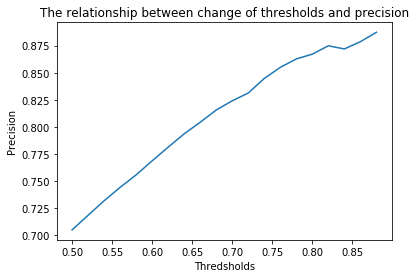

In [8]:
a = model.predict_classes(x_test)
y_pred = model.predict(x_test)
y_probas = model.predict_proba(x_test)
d = model.predict(x_test)
b = [i for i in a]
c = [i for i in y_test]
d = [i for i in d]
testdf = pd.DataFrame({'pred': b, 'prob': d, 'test': c})
testdf = testdf.sort_values(['pred'], ascending = False)
recalllist = []
thredlist = list(range(50, 90, 2))
for i in thredlist:
	tempdf = testdf[testdf['prob'] >= i / 100]
	recalllist.append(sum(tempdf['test'] == 1) / len(tempdf))
thredlist = list(map(lambda x : x / 100, thredlist))
plt.plot(thredlist, recalllist)
plt.xlabel('Thredsholds')
plt.ylabel('Precision')
plt.title('The relationship between change of thresholds and precision')

The result is very encouraging.
We use the trained models to predict out-of-sample data.
The graph above shows that if we increase the thredsholds of predicting labels as 1, the precision increases gradually. We have **75% probability to succeed** if we buy stocks with **model prediction probabilities more than 85%**. 

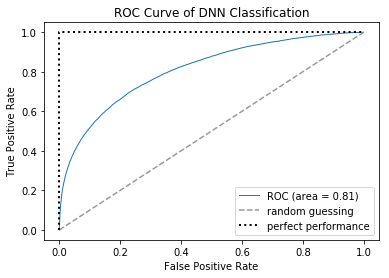

In [9]:
fpr, tpr, thresholds = roc_curve(y_test, y_probas, pos_label = 1)
roc_auc = auc(fpr, tpr)
plt.plot(fpr,tpr,lw =1, label = 'ROC (area = %.2f)' %(roc_auc))
plt.plot([0,1], [0,1], linestyle = '--', color = (0.6, 0.6, 0.6), label = 'random guessing')
plt.plot([0,0,1], [0,1,1], lw=2, linestyle = ':', color = 'black', label = 'perfect performance')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve of DNN Classification')
plt.legend(loc = 'lower right')

The ROC is 0.81, which is also another proof of the good result